<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>SVM, Kernel Trick (практика)</center></h2>

**Срок сдачи:** 24 апреля 2017, 06:00 <br> 
**Штраф за опоздание:** -2 балла после 06:00 24 апреля, -4 балла после 06:00 1 мая, -6 баллов после 06:00 8 мая

При отправлении ДЗ указывайте фамилию в названии файла<br>

Не забудьте создать задание в Slack через /todo.

Используйте данный Ipython Notebook при оформлении домашнего задания.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.svm import SVR, SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score
from collections import OrderedDict
from pylev import levenschtein
from Levenshtein import distance
from functools import partial
import cPickle

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

# Семинарская часть

Функция `select_model` принимает на вход обучающую выборку и возвращает модель (машину опорных векторов) с наилучшими параметрами для данной выборки. Эту функцию нужно реализовать.

Подбираемые параметры подели включают в себя:
- различные функции ядра (линейное, RBF, полиномиальные разных степеней)
- различные значения константы $C$ ($0, 0.1, 1, 10, 100, 1000, 10000$)

Подбирать параметры необходимо с помощью 10-fold кросс-валидации. Сейчас в качестве заглушки функция всегда возвращает линейный SVC.

In [41]:
def select_model(x, y):
    """
    Implement some model selection strategy here:
    seek through different kernels and parameters.

    Use a validation scheme to select the best model
    
    Quality metric: accuracy

    Returns:
        SVM classifier implemented by sklearn SVC class.
    """
    best_accuracy = 0
    best_model = None
    C_range = np.logspace(-1, 4, 6)
    
    param_grid_1 = {'kernel': ('linear', 'rbf'), 'C': C_range}
    param_grid_2 = {'kernel': ('poly',), 'C': C_range, 'degree': (2,3)}
    model = SVC()
    gs = GridSearchCV(model, [param_grid_1, param_grid_2], scoring='accuracy', cv=10, n_jobs=-1);
    gs.fit(x,y)

    best_model = gs.best_estimator_
    best_accuracy = gs.best_score_
    
    print "Best model %s, with accuracy %f" % (best_model, best_accuracy)
    return best_model

Далее две вспомогательные функции, которые отображают данные и разделяющую поверхность

In [42]:
def plot_data_set(x, y, description=''):
    print "Plotting data set points"
    plt.figure(figsize=(8, 8))

    colors = np.array(['r', 'b'])[y]
    plt.title(description, fontsize='small')
    plt.scatter(x[:, 0], x[:, 1], marker='o', c=colors, s=50)
    
def plot_decision_region(x1_min, x2_min, x1_max, x2_max, clf, n_points=1000):
    print "Plotting decision region"
    x1, x2 = np.meshgrid(np.linspace(x1_min, x1_max, n_points), np.linspace(x2_min, x2_max, n_points))
    z = clf.decision_function(np.c_[x1.ravel(), x2.ravel()]).reshape(x1.shape)

    plt.contour(x1, x2, z, levels=[0.0], linestyles='solid', linewidths=2.0)
    plt.contour(x1, x2, z, levels=[-1.0, 1.0], linestyles='dashed', linewidths=1.0)

Generating 'Linearly-separated' data set
Best model SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), with accuracy 0.970000
Plotting data set points
Plotting decision region


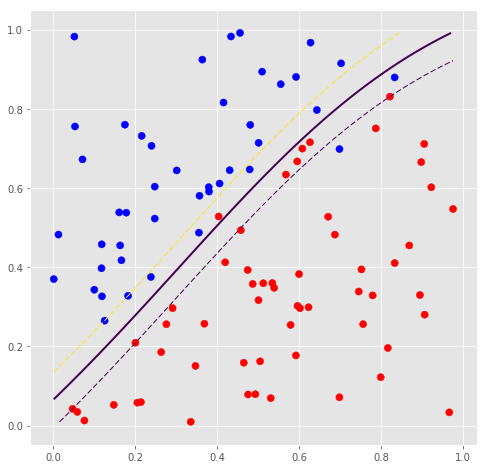

In [43]:
def generate_linear(size=100, k=1.1, b=0.0, nl=0.1):
    print "Generating 'Linearly-separated' data set"

    x = np.random.random((size, 2))
    y = np.zeros(size, dtype=int)
    noise = np.random.randn(size) * nl
    y[x[:, 1] - (k * x[:, 0] + b) > noise] = 1

    return x, y

x, y = generate_linear()
clf = select_model(x, y)
plot_data_set(x, y)
plot_decision_region(x[:, 0].min(), x[:, 1].min(), x[:, 0].max(), x[:, 1].max(), clf)

Generating 'Concentric circles' data set
Best model SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), with accuracy 0.960000
Plotting data set points
Plotting decision region


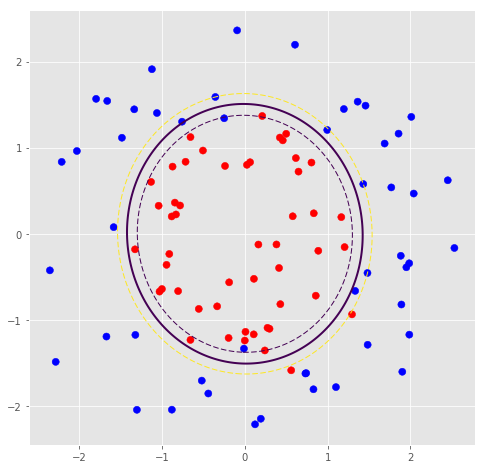

In [7]:
def generate_concentric(size=100, r1=1.0, r2=2.0, sigma=0.3):
    print "Generating 'Concentric circles' data set"
    x = np.zeros((size, 2))
    x[:size/2, 0] = sigma * np.random.randn(size/2) + r1
    x[size/2:, 0] = sigma * np.random.randn(size/2) + r2
    x[:, 1] = (np.random.random(size) - 0.5) * 2 * np.pi
    y = np.hstack([np.zeros(size/2, dtype=int), np.ones(size/2, dtype=int)])

    z = np.zeros((size, 2))
    z[:, 0] = x[:, 0] * np.cos(x[:, 1])
    z[:, 1] = x[:, 0] * np.sin(x[:, 1])

    return z, y

x, y = generate_concentric()
clf = select_model(x, y)
plot_data_set(x, y)
plot_decision_region(x[:, 0].min(), x[:, 1].min(), x[:, 0].max(), x[:, 1].max(), clf)

Generating 'Sinus-separated' data set
Best model SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), with accuracy 0.975000
Plotting data set points
Plotting decision region


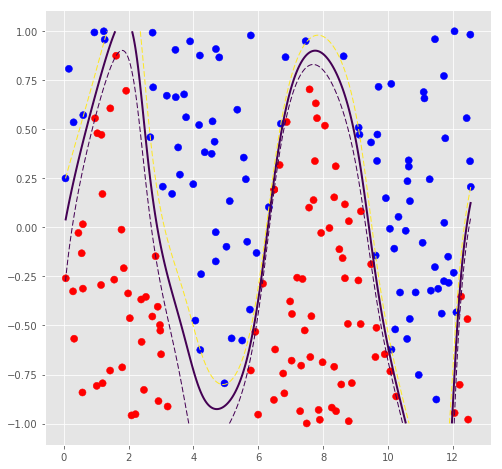

In [8]:
def generate_sin(size=200):
    print "Generating 'Sinus-separated' data set"

    x = np.random.random((size, 2))
    x[:, 0] = x[:, 0] * 4 * np.pi
    x[:, 1] = (x[:, 1] - 0.5) * 2
    y = np.zeros(size, dtype=int)
    y[x[:, 1] > np.sin(x[:, 0])] = 1

    return x, y

# this code runs for a long time!
#x, y = generate_sin()
#clf = select_model(x, y)
#plot_data_set(x, y)
#plot_decision_region(x[:, 0].min(), x[:, 1].min(), x[:, 0].max(), x[:, 1].max(), clf)

# Регрессия с SVM (3 балла)

Загрузите набор данных из *titanium.csv*<br/>
Мы будем решать задачу восстановления столбца 'y' по столбцу 'x'.

## Визуализация данных (1 балл)

Выполните стандартную предобработку данных (z-score) и выведите их на графике.

In [4]:
titanium_df = pd.read_csv('titanium.csv')
titanium_df_norm = (titanium_df - titanium_df.mean()).div(titanium_df.std())
titanium_df_norm.head()

,x,y
0,-1.679650,-0.428220
1,-1.609665,-0.486883
2,-1.539679,-0.444219
3,-1.469694,-0.414887
4,-1.399708,-0.406888


In [5]:
X = titanium_df_norm.values[:,0].reshape(-1,1)
y = titanium_df_norm.values[:,1]

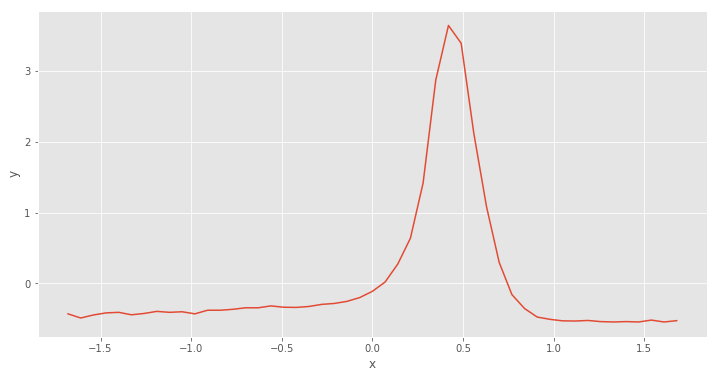

In [6]:
plt.xlabel("x")
plt.ylabel("y")
plt.plot(X, y, label='')

## Обучение моделей (2 балла)

Рассмотрите 3 ядра: 
* Линейное
* Полиномиальное (degree = 3, gamma = 6, coef0 = 1)
* RBF (gamma = 6, coef0 = 1)

Во всех случаях установить ширину трубки `epsilon=0.01`

Для каждого из ядер:
1. Пусть `C = np.logspace(-2, 2, 10)`. Постройте графики зависимости ошибки от параметра $C$ (ось графика со значениями параметра $C$ должна быть в логарифмической шкале). Ошибка измеряется как средняя абсолютная ошибка. 
2. Для наулучшего параметра $С$ каждого из ядер постройте график с данными и предстазанием по svm

В каких случаях возникает эффекты недообучения, переобучения?

 Построим графики зависимости $MAE$ от параметра $C$:

Best C for linear kernel is 0.01 MAE is 0.470979012451
Best C for poly kernel is 100.0 MAE is 0.41048172898
Best C for rbf kernel is 100.0 MAE is 0.058659531913


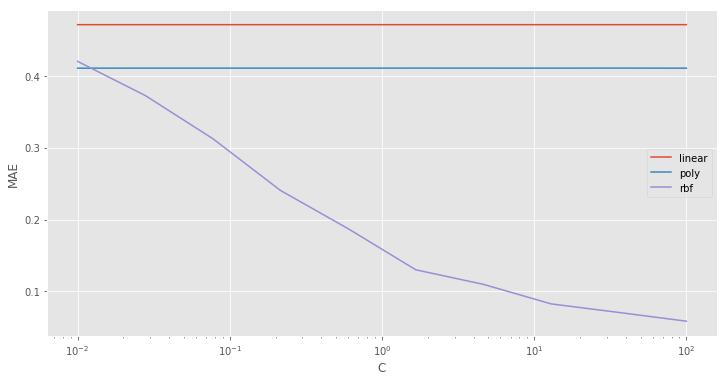

In [7]:
epsilon = 0.01
C_range = np.logspace(-2, 2, 10)
best_C = OrderedDict()
kernels = OrderedDict()
kernels['linear'] = {}
kernels['poly'] = {'degree': 3, 'gamma': 6, 'coef0': 1}
kernels['rbf'] = {'gamma': 6, 'coef0': 1}
plt.xlabel("C")
plt.ylabel("MAE")
plt.xscale('log')
for kernel, params in kernels.iteritems():
    maes = []
    best_mae = 1.0
    best_kernel_C = C_range[0]
    for C in C_range:
        svr = SVR(kernel=kernel, C=C, epsilon=epsilon, **kernels[kernel]).fit(X, y)
        cur_mae = mean_absolute_error(y, svr.predict(X))
        maes.append(cur_mae)
        if cur_mae < best_mae:
            best_mae = cur_mae
            best_kernel_C = C
    best_C[kernel] = best_kernel_C
    print "Best C for", kernel, "kernel is", best_kernel_C, "MAE is", best_mae
    plt.plot(C_range, maes, label=kernel)
plt.legend(loc='right')
plt.show()

Построим графики предсказаний для каждого из ядер для наилучших подобранных $C$:

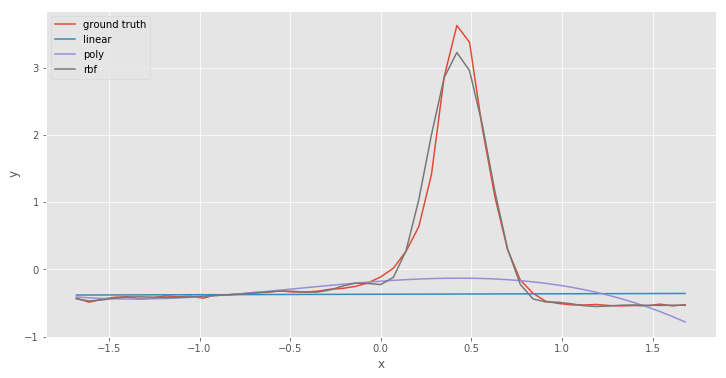

In [8]:
plt.xlabel("x")
plt.ylabel("y")
plt.plot(X, y, label='ground truth')
for kernel, C in best_C.iteritems():
    svr = SVR(kernel=kernel, C=C, epsilon=epsilon, **kernels[kernel]).fit(X, y)
    plt.plot(X, svr.predict(X), label=kernel)
plt.legend(loc='upper left')

Как видно из графиков, наилучшую точность даёт ядро $rbf$ при $C$ = 10$^2$.<br>
$C$ в случае линейного и полиномиального ядер не влияет на $MAE$. На последнем графике видно явное недообучение SVR с использованием этих ядер, а также возможное переобучение с использованием ядра $rbf$.

# Определение языка слова (7 баллов)

В данном задании вам необходимо определить, на каком языке написано слово.

Вам будет дано два текста - первые предложения произведения "Война и Мир" на английком и испанском, разбитые на слова. У слов нет общепринятого числового представления, поэтому мы предлагаем вам реализовать собственноге ядро для SVM, основанное на редакторском расстоянии или [расстоянии Левинштейна](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%9B%D0%B5%D0%B2%D0%B5%D0%BD%D1%88%D1%82%D0%B5%D0%B9%D0%BD%D0%B0). 

Имплементировать расстояние Леванштейна не нужно - можно взять любую доступную реализацию, например [здесь](https://github.com/toastdriven/pylev) или [здесь](https://github.com/ztane/python-Levenshtein).

## Загрузка (1 балл)

Загрузите данные из файлов *war_and_peace_es.txt* и *war_and_peace_en.txt*.<br/> 
В результате вы должны получить pandas.DataFrame со столбцами *index* | *word* | *label*, где *index* - это индекс pandas, *word* - это слово и *label* - это метка класса (0 или 1)

In [2]:
en_wap_df = pd.read_csv('war_and_peace_en.txt', header=None, names=['word'])
es_wap_df = pd.read_csv('war_and_peace_es.txt', header=None, names=['word'])
en_wap_df['label'] = np.zeros(en_wap_df.shape[0], dtype=np.int8)
es_wap_df['label'] = np.ones(es_wap_df.shape[0], dtype=np.int8)
wap_df = pd.concat([en_wap_df, es_wap_df], axis=0).reset_index(drop=True)
print wap_df.shape
wap_df.head()

(11403, 2)


,word,label
0,war,0
1,and,0
2,peace,0
3,leo,0
4,tolstoy,0


## Подготовка данных (2 балла)

Особенностью пользовательского ядра в sklean.SVC является то, что на вход оно должно принимать именно вектора чисел.<br/>
В нашем случае это будут индексы соответствующих слов из корпуса. То есть вместо вектора ['treat', 'celebrit', 'prince', ...] на вход в ядро подается вектор из индексов [9209, 11145, 7735, ...] с помощью которых вы будете находить сами слова.

Прежде чем мы начнем строить ядро, надо подготовить данные. Для этого:
1. Задайте переменную RND_SEED, которая будет использоваться в любых генераторах случайных чисел в вашем коде (обычно параметр "random_seed")
2. Случайным образом перемешайте и заново проиндексируйте таблицу, полученную выше (используйте методы df.sample() и df.reset_index())
3. Ядро может вычисляться достаточно долго, поэтому можете урезать таблицу, но оставить в ней не менее 1000 слов.
4. Разбейте данные на обучающую и контрольную выборку в пропорции 60/40

В результате вы должны получить вектор-столбец X_train, X_test с **индексами** слов и векторы y_train, y_test с метками классов.

In [3]:
RND_SEED = 42

In [4]:
wap_df = wap_df.sample(frac=1, random_state=RND_SEED).reset_index()
print wap_df.shape
wap_df.head()

(11403, 3)


,index,word,label
0,7739,funzionavano,1
1,1835,better,0
2,3761,eagerness,0
3,11204,gusterebbe,1
4,1608,was,0


Создадим словарь всех слов:

In [18]:
D = wap_df[['index', 'word']].set_index('index').to_dict(orient='dict')['word']

In [24]:
print wap_df[wap_df['index'] == 89]

      index      word  label
9710     89  favorite      0


Возьмём обучающую и тестовую подвыборки, суммарный размер которых чуть больше 1000, 60% - обучающей подвыборки, 40% - тестовой

In [42]:
min_dataset_size = 1000
fraction = float(min_dataset_size) / float(wap_df.shape[0])
X = wap_df.loc[:, 'index'].values[:, np.newaxis]
y = wap_df.loc[:, 'label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=fraction * 0.6, 
                                                    test_size=fraction * 0.4,
                                                    stratify=y,
                                                    random_state=RND_SEED)
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(599L, 1L) (401L, 1L) (599L,) (401L,)


## Расчет ядра (3 балла)

Некоторые указания по составлению пользовательского ядра можно найти [здесь](http://stackoverflow.com/questions/26962159/how-to-use-a-custom-svm-kernel).

Если в двух словах:<br/>
Функция, реазлизующая расчет ядра должна принимать две матрицы $U$ и $V$ с признаковым описанием объектов (во время обучения они обе относятся к обучающей выборке, а во время применения - одна матрица относится к обучающей выборке, а другая к контрольной).

В результате, функция должна возвращать матрицу ядра $G_{ij} = K(U_i, V_j)$.

Таким образом, в этом задании вам надо:
1. Написать функцию *string_kernel(U, V)*, расчитывающее матрицу ядра $G_{ij}$
2. Визуализировать матрицу только для обучающей выборки (функция plt.imshow()).

**ВАЖНО**<br/>
На лекции мы рассмотрели, что ядро должно обладать определенными свойствами, поэтому не получится рассчитать $G_{ij}$ как расстояние Левинштейна между словами $\text{word}_i$ и $\text{word}_j$.<br/>
Вместо этого используйте какое-нибудь готовое ядро, зависящее от расстояние между объектами.

Возьмём ядро $rbf$, т.к. оно зависит от расстояния между объектами.<br>
Реализуем два ядра: классическое $rbf$, и $laplacian$:

In [6]:
def rbf(metric, x1, x2, gamma, degree):
    return np.exp(-gamma * np.power(metric(x1, x2), degree))

def laplacian_kernel_leven(x1, x2, gamma):
    #return rbf(levenschtein, x1, x2, gamma, 1)
    return rbf(distance, x1, x2, gamma, 1)

def rbf_kernel_leven(x1, x2, gamma):
    #return rbf(levenschtein, x1, x2, gamma, 2)
    return rbf(distance, x1, x2, gamma, 2)

Функция подсчёта матрицы скалярных произведений объектов в спрямляющем пространстве (с использованием Kernel Trick):

In [7]:
def string_kernel_proxy(U, V, kernel, gamma, dictionary):
    G = np.empty((U.shape[0], V.shape[0]), dtype=np.float64)
    for i, x in enumerate(U):
        for j, y in enumerate(V):
            G[i, j] = kernel(dictionary[x[0]], dictionary[y[0]], gamma)
    return G

Обёртка над string_kernel_proxy, имющая интерфейс, необходимый для функции ядра в sklearn:

In [45]:
string_kernel = partial(string_kernel_proxy, kernel=rbf_kernel_leven, gamma=0.1, dictionary=D)

Подсчёт и визуализация матрицы скалярных произведений:

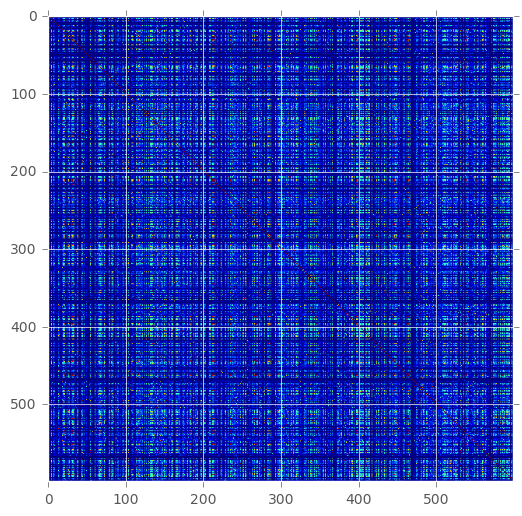

In [46]:
G = string_kernel(X_train, X_train)
plt.imshow(G)

## Оценка качества (1 балл)

Обучите метод опорных векторов с различными значениями параметра штрафа $C$.<br/>
Для каждого значения выведите accuracy на обучащюей и контрольной выборке.

Постарайтесь достичь качества в 70% на тестовой выборке

Переберём параметры: ядро, $\gamma$, $C$ и выберем наилучшие с точки зрения accuracy:

In [22]:
# this code runs for a long time!
#for base_kernel in (laplacian_kernel_leven, rbf_kernel_leven):
    #for gamma in np.logspace(-2, 2, 5):
        #string_kernel = partial(string_kernel_proxy, kernel=base_kernel, gamma=gamma, dictionary=D)
        #for C in np.logspace(-2, 2, 5):
            #svc = SVC(C=C, kernel=string_kernel, random_state=RND_SEED).fit(X_train, y_train)
            #train_accuracy = accuracy_score(y_train, svc.predict(X_train))
            #test_accuracy = accuracy_score(y_test, svc.predict(X_test))
            #print "kernel:", base_kernel.__name__, ", gamma:", gamma, ", C:", C
            #print "Accuracy on train data:", train_accuracy
            #print "Accuracy on test data: ", test_accuracy

kernel: laplacian_kernel_leven , gamma: 0.01 , C: 0.01
Accuracy on train data: 0.557595993322
Accuracy on test data:  0.558603491272
kernel: laplacian_kernel_leven , gamma: 0.01 , C: 0.1
Accuracy on train data: 0.557595993322
Accuracy on test data:  0.558603491272
kernel: laplacian_kernel_leven , gamma: 0.01 , C: 1.0
Accuracy on train data: 0.764607679466
Accuracy on test data:  0.715710723192
kernel: laplacian_kernel_leven , gamma: 0.01 , C: 10.0
Accuracy on train data: 0.797996661102
Accuracy on test data:  0.815461346633
kernel: laplacian_kernel_leven , gamma: 0.01 , C: 100.0
Accuracy on train data: 0.729549248748
Accuracy on test data:  0.72319201995
kernel: laplacian_kernel_leven , gamma: 0.1 , C: 0.01
Accuracy on train data: 0.557595993322
Accuracy on test data:  0.558603491272
kernel: laplacian_kernel_leven , gamma: 0.1 , C: 0.1
Accuracy on train data: 0.671118530885
Accuracy on test data:  0.665835411471
kernel: laplacian_kernel_leven , gamma: 0.1 , C: 1.0
Accuracy on train dat

Лучшие параметры для ядра $laplacian$ на обучающей и тестовой выборках:<br>
$\gamma$ = 1.0, $C$ = 100.0<br>
Accuracy on train data: 0.993322203673<br>
Accuracy on test data:  0.84289276808<br>

Лучшие параметры для ядра $rbf$ на обучающей выборке:<br>
$\gamma$ = 1.0, $C$ = 100.0<br>
Accuracy on train data: 0.993322203673<br>
Accuracy on test data:  0.765586034913<br>
Лучшие параметры для ядра $rbf$ на тестовой выборке:<br>
$\gamma$ = 0.1, $C$ = 1.0<br>
Accuracy on train data: 0.863105175292<br>
Accuracy on test data:  0.785536159601<br>

Как видно, ядро $laplacian$ лучше подходит для анализа текста в данной задаче.<br>
Обучим и оценим модель с этим ядром с наилучшими подобранными параметрами $\gamma$ = 1.0, $C$ = 100.0 на всех данных.

Разобьём все данные на обучающую и тестовую подвыборки, с отношением 60/40:

In [51]:
X = wap_df.loc[:, 'index'].values[:, np.newaxis]
y = wap_df.loc[:, 'label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, 
                                                    test_size=0.4,
                                                    stratify=y,
                                                    random_state=RND_SEED)
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(6841L, 1L) (4562L, 1L) (6841L,) (4562L,)


Обучим модель, посчитаем accuracy на обучающих и тестовых данных:

In [52]:
#string_kernel = partial(string_kernel_proxy, kernel=laplacian_kernel_leven, gamma=1.0, dictionary=D)
#svc = SVC(C=100.0, kernel=string_kernel, random_state=RND_SEED).fit(X_train, y_train)
#train_accuracy = accuracy_score(y_train, svc.predict(X_train))
#test_accuracy = accuracy_score(y_test, svc.predict(X_test))
#print "Accuracy on train data:", train_accuracy
#print "Accuracy on test data: ", test_accuracy

Accuracy on train data: 0.988305803245
Accuracy on test data:  0.927224901359


Так как процесс обучения на всех обучающих данных занимает значительное время, сериализуем обученный классификатор, и при повторном прогоне кода нужно будет лишь десериализовать объект, и запустить predict метод.

In [36]:
#with open('best_svc.pkl', 'wb') as fid:
    #cPickle.dump(svc, fid)

Десериализуем объект обученного на всех обучающих данных классификатора, и предскажем классы слов в тестовой подвыборке:

In [35]:
with open('best_svc.pkl', 'r') as fid:
    svc_loaded = cPickle.load(fid)

In [100]:
print "Accuracy on test data: ", accuracy_score(y_test, svc_loaded.predict(X_test))

Accuracy on test data:  0.927224901359


<h3>Проверка на новых, вручную введённых данных</h3>

In [36]:
def get_index(word, dictionary):
    for k, v in dictionary.iteritems():
        if word == v:
            return k
    return 0

def add_to_dict(df, word_col, dictionary):
    next_word = np.max(dictionary.keys()).astype(int) + 1
    for word in df[word_col]:
        if word not in dictionary.values():
            dictionary[next_word] = word
            next_word += 1
    return dictionary

In [37]:
D = wap_df[['index', 'word']].set_index('index').to_dict(orient='dict')['word']

In [44]:
manual_test_df = pd.read_csv("manual_test.txt", header=None, names=['word'])
add_to_dict(manual_test_df, 'word', D)
manual_test_df['index'] = manual_test_df.word.apply(lambda row: get_index(row, D))
X_manual = manual_test_df['index'].values.reshape(-1, 1)
# it`s possible to change dict only with changing the kernel
string_kernel = partial(string_kernel_proxy, kernel=laplacian_kernel_leven, gamma=1.0, dictionary=D)
svc_loaded.kernel = string_kernel
predicted_manual = svc_loaded.predict(X_manual)
manual_test_df = pd.concat([manual_test_df, pd.DataFrame(predicted_manual, 
                                                         columns=['language'], 
                                                         index=manual_test_df.index)], axis=1)
print accuracy_score(en_wap_df.iloc[:len(predicted_manual)]['label'], predicted_manual)
manual_test_df.loc[manual_test_df['language'] == 1, 'language'] = 'Spain'
manual_test_df.loc[manual_test_df['language'] == 0, 'language'] = 'English'
manual_test_df

0.92


,word,index,language
0,war,0,English
1,and,1,English
2,peace,2,English
3,leo,3,English
4,tolstoy,4,Spain
5,book,5,English
6,one,6,English
7,chapter,7,English
8,well,8,English
9,prince,9,English
